In [1]:
import xarray as xr
import rioxarray
import pandas as pd
import geopandas as gpd
import numpy as np
from glob import glob
import h5py
import cartopy
import pyart
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
# pyplot needed to plot the dataset, but animation only needed much further down.
from matplotlib import animation
%matplotlib inline
from netCDF4 import Dataset, date2num
# This is needed to display graphics calculated outside of jupyter notebook
from IPython.display import HTML, display
import os
import sys
sys.path.append('~/PlotGallery')
from matplotlibconfig import basic
basic()


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
dict_hurricanes= {
    'Barry': {'datetime': [], 'points':[]},
    'Beta': {'datetime': [], 'points':[]},
    'Cindy': {'datetime': [], 'points':[]},
    'Delta': {'datetime': [], 'points':[]},
    'Hanna': {'datetime': [], 'points':[]},
    'Harvey': {'datetime': [], 'points':[]},
    'Imelda': {'datetime': [], 'points':[]},
    'Laura': {'datetime': [], 'points':[]},
    'Florence': {'datetime': [], 'points': []}
}

In [3]:
for event in dict_hurricanes.keys():
    fname= glob('tracks/%s/*_pts.shp'%(event))[0]
    pnts= gpd.read_file(fname)
    pnts.DTG= pd.to_datetime(pnts.DTG, format='%Y%m%d%H')
    dict_hurricanes[event]['datetime']= sorted(pnts.DTG.tolist())
    order= np.argsort(pnts.DTG.values)
    dict_hurricanes[event]['points']= list(zip(pnts.LON.values[order], pnts.LAT.values[order]))

In [4]:
AOI= gpd.read_file('area/great_extent.shp').to_crs('EPSG:4326')

### Process MRMS

In [5]:
base_dir= '/media/scratch/ZhiLi/MRMS'
xx = xr.open_rasterio(os.path.join(base_dir, 'GaugeCorr_QPE_01H_00.00_20170101-000000.grib2.tif')).x
for event in dict_hurricanes.keys():
    if event=='Florence':
        start= dict_hurricanes[event]['datetime'][34]
        end= dict_hurricanes[event]['datetime'][-1]
        fnames= [os.path.join(base_dir, dt.strftime('GaugeCorr_QPE_01H_00.00_%Y%m%d-%H0000.grib2.tif')) for dt in pd.date_range(start, end, freq='H')]
        time= xr.Variable('time', pd.date_range(start, end, freq='H'))
        rains= [xr.open_rasterio(fn).squeeze().assign_coords({'x': xx-360}).rio.clip([AOI.geometry[0]]) for fn in fnames]
        rains = xr.concat(rains, dim=time)
        break
#         cliped= rains.rio.clip(AOI)

In [49]:
for dt in rains.time.values:
    dt= pd.to_datetime(dt)
    with Dataset('data/rain/Florence/MRMS_%s.nc'%dt.strftime('%Y%m%d_%H%M%S'), 'w', format='NETCDF4_CLASSIC') as nc:
        nc.FileOrigins = "None"
        nc.MET_version = "V10.0.0"
        nc.MET_tool = "pcp_combine"
        nc.RunCommand= ""
        nc.Projection = "LatLon"
        nc.hemisphere = "N"
        nc.Nlat = "%d"%len(rains.y)
        nc.Nlon = "%d"%len(rains.x)
        nc.delta_lat= "0.01"
        nc.delta_lon= "0.01"
        nc.lon_ll= "-82.0"
        nc.lat_ll= "30.0"
        
        nc.createDimension('lat', len(rains.y))
        nc.createDimension('lon', len(rains.x))
#         nc.createDimension('time', len(rains.time))

        
        lat = nc.createVariable('lat', 'f4', ('lat', 'lon'), zlib=True, complevel=9,fill_value=-9999)    
        lon = nc.createVariable('lon', 'f4', ('lat', 'lon'), zlib=True, complevel=9,fill_value=-9999)
        precip= nc.createVariable('APCP', 'f4', ('lat', 'lon'), zlib=True,complevel=9, fill_value=-9999)
#         time= nc.createVariable('time', np.int32, 'time', zlib=True,complevel=9, fill_value=-9999)

#         print(precip.shape)

        lon[:]= lon2d
        lon.units= 'degrees_east'
        lon.long_name="longitude"
        lon.standard_name = "longitude"
    #     lon.axis = 'X'

        lat[:]= lat2d
        lat.units= 'degrees_north'
        lat.long_name="latitude"
        lat.standard_name = "latitude"    
        
        precip[:]= np.flip(rains.sel(time=dt).fillna(-9999.).values.astype(np.float32), axis=0)
        precip.units='mm/h'
        precip.long_name= "precipitation"
        precip.standard_name = "Instantaneous precipitatin rates"
        precip.missing_value= -9999.
        precip.level= "A01"
#         precip._FillValue= -9999.
        precip.init_time= dt.strftime("%Y%m%d_%H%M%S")
        precip.init_time_ut= str(int(dt.timestamp()))
        precip.valid_time= dt.strftime("%Y%m%d_%H%M%S")
        precip.valid_time_ut= str(int(dt.timestamp()))
        precip.accum_time= "010000"
        precip.accum_time_sec= 3600        
    #     lat.axis='Y'
#         ref= 'hours since 2015-01-01 00:00:00'
#         time[:]= [date2num(dt, ref) for dt in pd.to_datetime(rains.time.values)]
#         time.unit= ref
#         time.calendar='standard'

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 1064

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 883

### Process Stage IV

In [26]:
base_dir= '/media/scratch/ZhiLi/StageIV'

for event in dict_hurricanes.keys():
    if event=='Florence':
        start= dict_hurricanes[event]['datetime'][34]
        end= dict_hurricanes[event]['datetime'][-1]
        fnames= [os.path.join(base_dir, dt.strftime('ST4.%Y%m%d%H.01h')) for dt in pd.date_range(start, end, freq='H')]
        time= xr.Variable('time', pd.date_range(start, end, freq='H'))
        rains= [xr.open_rasterio(fn).squeeze().rio.reproject('epsg:4326').sel(x=slice(-87, -74),
                                                                              y=slice(41,30)) for fn in fnames]
        rains = xr.concat(rains, dim=time)
        break
#         cliped= rains.rio.clip(AOI)

In [31]:
lon2d, lat2d= np.meshgrid(rains.x.values, rains.y.values[::-1])

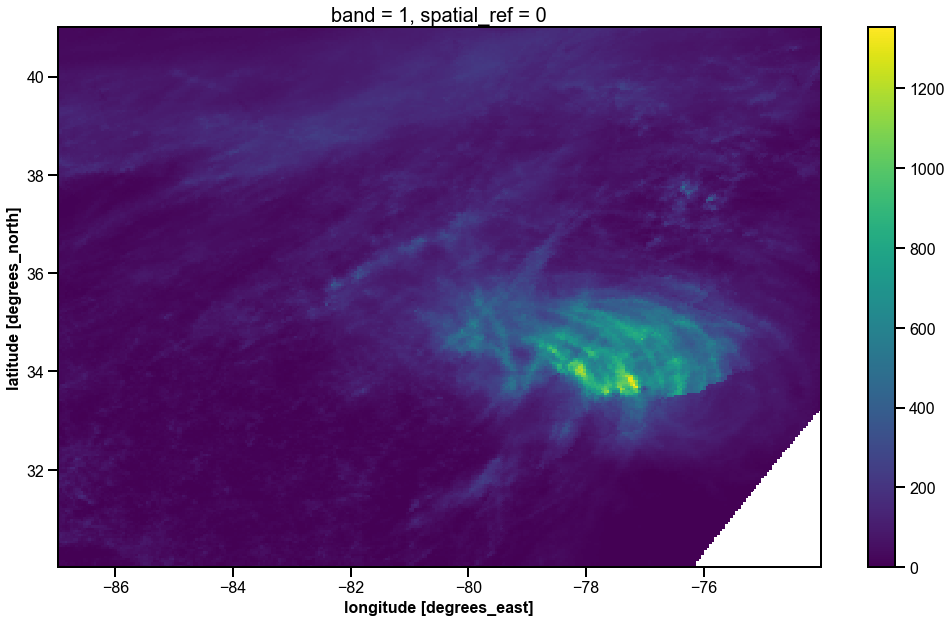

In [49]:
rains.sum(dim='time').where(rains.sum(dim='time')>=0).plot()

In [42]:
for dt in rains.time.values:
    dt= pd.to_datetime(dt)
    with Dataset('data/rain/Florence/StageIV_%s.nc'%dt.strftime('%Y%m%d_%H%M%S'), 'w', format='NETCDF4_CLASSIC') as nc:
        nc.FileOrigins = "None"
        nc.MET_version = "V10.0.0"
        nc.MET_tool = "pcp_combine"
        nc.RunCommand= ""
        nc.Projection = "LatLon"
        nc.hemisphere = "N"
        nc.Nlat = "%d"%len(rains.y)
        nc.Nlon = "%d"%len(rains.x)
        nc.delta_lat= "0.04427"
        nc.delta_lon= "0.04427"
        nc.lon_ll= "-86.96"
        nc.lat_ll= "30.04"
        
        nc.createDimension('lat', len(rains.y))
        nc.createDimension('lon', len(rains.x))
#         nc.createDimension('time', len(rains.time))

        
        lat = nc.createVariable('lat', 'f4', ('lat', 'lon'), zlib=True, complevel=9,fill_value=-9999)    
        lon = nc.createVariable('lon', 'f4', ('lat', 'lon'), zlib=True, complevel=9,fill_value=-9999)
        precip= nc.createVariable('APCP', 'f4', ('lat', 'lon'), zlib=True,complevel=9, fill_value=-9999)
#         time= nc.createVariable('time', np.int32, 'time', zlib=True,complevel=9, fill_value=-9999)

#         print(precip.shape)

        lon[:]= lon2d
        lon.units= 'degrees_east'
        lon.long_name="longitude"
        lon.standard_name = "longitude"
    #     lon.axis = 'X'

        lat[:]= lat2d
        lat.units= 'degrees_north'
        lat.long_name="latitude"
        lat.standard_name = "latitude"    
        
        vals= rains.values
        vals[vals==9999.]= -9999.
        precip[:]= np.flip(rains.sel(time=dt).fillna(-9999.).values.astype(np.float32), axis=0)
        precip.units='mm/h'
        precip.long_name= "precipitation"
        precip.standard_name = "Instantaneous precipitatin rates"
        precip.missing_value= -9999.
        precip.level= "A01"
#         precip._FillValue= -9999.
        precip.init_time= dt.strftime("%Y%m%d_%H%M%S")
        precip.init_time_ut= str(int(dt.timestamp()))
        precip.valid_time= dt.strftime("%Y%m%d_%H%M%S")
        precip.valid_time_ut= str(int(dt.timestamp()))
        precip.accum_time= "010000"
        precip.accum_time_sec= 3600        
    #     lat.axis='Y'
#         ref= 'hours since 2015-01-01 00:00:00'
#         time[:]= [date2num(dt, ref) for dt in pd.to_datetime(rains.time.values)]
#         time.unit= ref
#         time.calendar='standard'

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

<class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 248

<class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 293

## Prepare WRF output

In [2]:
nc= Dataset('')

In [4]:
nc.close()

In [11]:
from wrf import getvar, ALL_TIMES, extract_times,ll_to_xy

In [ ]:
times= extract_times()

In [30]:
first=True
with Dataset("data/rain/gfs_2domains_091212/wrfout_d02_2018-09-12_12:00:00", 'r') as src:
    times= extract_times(src, ALL_TIMES)
    rains= src['RAINNC']
    for i,dt in enumerate(times):
        print(dt)
        dt= pd.to_datetime(dt)
        with Dataset('data/rain/Florence_run1/%s'%dt.strftime('Run1_%Y%m%d_%H%M%S.nc'),
                     'w', format='NETCDF4_CLASSIC') as dst:
            dst.FileOrigins = "None"
            dst.MET_version = "V10.0.0"
            dst.MET_tool = "pcp_combine"
            dst.RunCommand= ""
            # copy global attributes all at once via dictionary
            dst.setncatts(src.__dict__)

            dst.createDimension('y', 159)
            dst.createDimension('x', 198)
            # copy all file data except for the excluded
            var= src['PREC_ACC_NC']
            x= dst.createVariable('APCP', var.datatype, ('y', 'x'))
            if first:
                x[:]= rains[:][0]
                first=False
            else:
                x[:]= rains[:][i]- rains[:][i-1]
#             x.setncatts(var.__dict__)
            x.units='mm/h'
            x.level= "A01"
            x.long_name= "precipitation"
            x.standard_name = "Instantaneous precipitatin rates"        
            x.init_time= dt.strftime("%Y%m%d_%H%M%S")
            x.init_time_ut= str(int(dt.timestamp()))
            x.valid_time= dt.strftime("%Y%m%d_%H%M%S")
            x.valid_time_ut= str(int(dt.timestamp()))
            x.accum_time= "010000"
            x.accum_time_sec= 3600 

            x = dst.createVariable('x', variable.datatype, ('y', 'x'))
            x[:] = src['XLONG'][:][0]
            x.units= 'degrees_east'
            x.long_name="longitude"
            x.standard_name = "longitude"
            
            y = dst.createVariable('y', variable.datatype, ('y', 'x'))
            y[:] = src['XLAT'][:][0]
            y.units= 'degrees_north'
            y.long_name="latitude"
            y.standard_name = "latitude"
                    # copy variable attributes all at once via dictionary
#                     x.setncatts(src[name].__dict__)


2018-09-12T12:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T13:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T14:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T15:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T16:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T17:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T18:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T19:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T20:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T21:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T22:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-12T23:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T00:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T01:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T02:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T03:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T04:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T05:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T06:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T07:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T08:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T09:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T10:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T11:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T12:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T13:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T14:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T15:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T16:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T17:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T18:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T19:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T20:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T21:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T22:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-13T23:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T00:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T01:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T02:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T03:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T04:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T05:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T06:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T07:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T08:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T09:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T10:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T11:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T12:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T13:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T14:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T15:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T16:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T17:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T18:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T19:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T20:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T21:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T22:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-14T23:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T00:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T01:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T02:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T03:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T04:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T05:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T06:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T07:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T08:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T09:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T10:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T11:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T12:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T13:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T14:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T15:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T16:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T17:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T18:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T19:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T20:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T21:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T22:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-15T23:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T00:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T01:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T02:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T03:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T04:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T05:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T06:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T07:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T08:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T09:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T10:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T11:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T12:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T13:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T14:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T15:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T16:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T17:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T18:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T19:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T20:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T21:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T22:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-16T23:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T00:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T01:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T02:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T03:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T04:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T05:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T06:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T07:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T08:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T09:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T10:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T11:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T12:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T13:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T14:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T15:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T16:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T17:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T18:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T19:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T20:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T21:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T22:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-17T23:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T00:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T01:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T02:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T03:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T04:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T05:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T06:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T07:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T08:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T09:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T10:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T11:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T12:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T13:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T14:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T15:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T16:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T17:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T18:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T19:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T20:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T21:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T22:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-18T23:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198

2018-09-19T00:00:00.000000000


<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 159

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 198